<center><h1><b>Analizando los crímenes en la Ciudad de Nueva York</b></h1></center>

---

## **1- Descripción del problema**

Para este problema, nos entregan datos públicos del departamendo de policía de New York. El dataset viene con el nombre stop_and_frist_data y este contiene información sobre detenciones realizadas por la policia de Nueva York en vía pública. Además, nos entregan un diccionario con las características de los atributos en un archivo llamado 2009 SQF File Spec.xlsx.

Con este dataset debemos armar dos modelos, uno que prediga si la detención terminará en arresto y otro si habrá violencia en el procedimiento. El conjunto de datos viene dividido en dos partes:

* 2009_1perc.csv: Datos de entrenamiento.

* 2010_1perc.csv: Datos de validación.

Para predecir si la detención terminará en arresto, la variable objetivo será **arstmade** y para determinar si habrá violencia en el procedimiento, crearemos una variable llamada **violence**, la cuál nace a partir de columnas que indican violencia en el procedimiento, esta marcará como 1 si en cualquiera de estas columnas se indica un tipo de violencia y 0 si en ninguna de estas se observa violencia.

Al ser las dos variables objetivo discretas, trataremos al problema con **Modelos de Clasificación**. Más adelante declararemos una grilla de búsqueda tentativa con los respectivos modelos e hiperparámetros.

Como requerimiento nos piden lo siguiente:

* Para el problema de arresto, debemos entrenar 3 modelos y encontrar el más satisfactorio, reportando dos métricas de desempeño.

* Para el problema de violencia, debemos entrenar 5 modelos y serializar los dos mejores para enviar a evaluación.

* Reportar la probabilidad de que un sujeto sea arrestado en uno de los cinco barrios, condicional al género y raza. De esto debemos sacar conclusiones, si es que hay implicancias éticas.

* Utilizar archivo preproc_nyc_sqf.py en dataframe para igualar benchmark y obtener un dataframe apto para entrenamiento.

El procedimiento para esta problemática es la siguiente:

* Procesar dataframe con función auxiliar "create_suitable_dataframe" del archivo preproc_nyc_sqf.py que nos entregan.
* Exploración de variables perdidas.
* Reporte de probabilidades.
* Modelo Arstmade:
    - Binarizar variable objetivo en conjunto de entrenamiento y validación.
    - Obtener variables con mayor correlación.
    - Exploración de atributos y variable objetivo.
    - Entrenamiento de modelos con grilla de búsqueda.
    - Elegir mejor modelo y reportar desempeño.
* Modelo Violence:
    - Crear nueva variable a partir de columnas pf_.
    - Exploración de atributos y variable objetivo.
    - Entrenamiento de modelos con grilla de búsqueda.
    - Encontrar los dos mejores modelos, serializarlos y reportar desempeño.

> **Debido a que realizaremos dos modelaciones distintas, a partir de la exploración y entrenamiento, dividiremos el notebook en "Arstmade" y "Violence", realizando los procedimientos por separado.**

### **1.1 Métricas y división de muestras**

#### **Métricas**

Para medir el **desempeño de los Modelos de Clasificación** y obtener los dos mejores, decidiremos las métricas en función al balance de Clases, si está desbalanceada optaremos por el F1 y si no, por accuracy. El proceso será el siguiente:

* Realizamos una búsqueda de grilla con GridSearchCV, con un Kfold de 5.

* Con el best estimator de cada modelo predecimos en conjunto de validación que nunca entró en la Grilla de Búsqueda.

* Con los datos predichos, obtenemos un Puntaje de Validación y elegimos mejor modelo a partir del puntaje, evaluando Underfitting y Overfitting.

#### **División de muestras**

Nos entregan un archivo completo de entrenamiento y otro de validación, ya que debemos realizar modelamiento en dos variables objetivo, la división de muestras quedaría de la siguiente forma:

**Modelo para predecir arresto:**

* **X_train:** Atributos con mayor correlación con variable objetivo del archivo 2009_1perc.csv

* **X_test:** Atributos de validación del archivo 2010_1perc.csv

* **y_train:** Variable objetivo arstmade para entrenamiento proveniente del archivo 2009_1perc.csv

* **y_test:** Variable objetivo arstmade para validación proveniente del archivo 2010_1perc.csv

**Modelo para predecir violencia:**

* **X_train:** Atributos con mayor correlación con variable objetivo creada como "violence" del archivo 2009_1perc.csv

* **X_test:** Atributos de validación del archivo 2010_1perc.csv

* **y_train:** Variable objetivo creada como "violence" para entrenamiento, proveniente del archivo 2009_1perc.csv

* **y_test:** Variable objetivo creada como "violence" para validación, proveniente del archivo 2010_1perc.csv

---

<center><h1><b>Aspectos Computacionales</b></h1></center>

Sección donde se entregará a detalle las librerías a utilizar, preprocesamiento de variables y grilla tentativa de modelos con sus hiperparámetros a buscar.

## **2.1 Librerías**

Las librerías a utilizar serán las siguientes:

#### **Ingesta de datos**

In [1]:
import pandas as pd

#### **Preprocesamiento**

In [2]:
import numpy as np
import preproc_nyc_sqf
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.selection import DropFeatures
from sklearn.preprocessing import StandardScaler
from functions import SelectFeatures, del_first_zero, gridsearch_train

#### **Visualización**

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msngo
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame
import geopandas as gpd
import contextily as cx

warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10, 6)

#### **Modelación**

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

#### **Evaluación**

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score

**Serialización**

In [6]:
from joblib import dump, load

## **2.2 Detalles de ingeniería de atributos**

Sección donde comienza la ingesta de datos, preprocesamiento de estos, detalle del proceso y grilla de modelos con hiperparámetros a buscar.

**Ingestamos datos**

In [7]:
df = pd.read_csv('2009_1perc.csv').drop(columns='Unnamed: 0')

df_val = pd.read_csv('2010_1perc.csv').drop(columns='Unnamed: 0')

**Aplicamos función create_suitable_dataframe**

El dataframe viene con muchas columnas que tienen datos vacios y que contienen muchas categorias dentro de una sola variable, por lo tanto, nos entregan un archivo de preprocesamiento que nos devuelve un dataframe apto para entrenamiento, por lo que procedemos a aplicarlo:

In [8]:
df_prep, suitable_cat_att, suitable_num_att = preproc_nyc_sqf.create_suitable_dataframe(df)

['year', 'pct', 'ser_num', 'datestop', 'timestop', 'perstop', 'compyear', 'comppct', 'repcmd', 'revcmd', 'dob', 'age', 'ht_feet', 'ht_inch', 'weight', 'addrpct', 'linecm', 'detailcm', 'perobs']


## **2.3 Explorando datos perdidos luego de utilizar preproc_nyc_sqf**

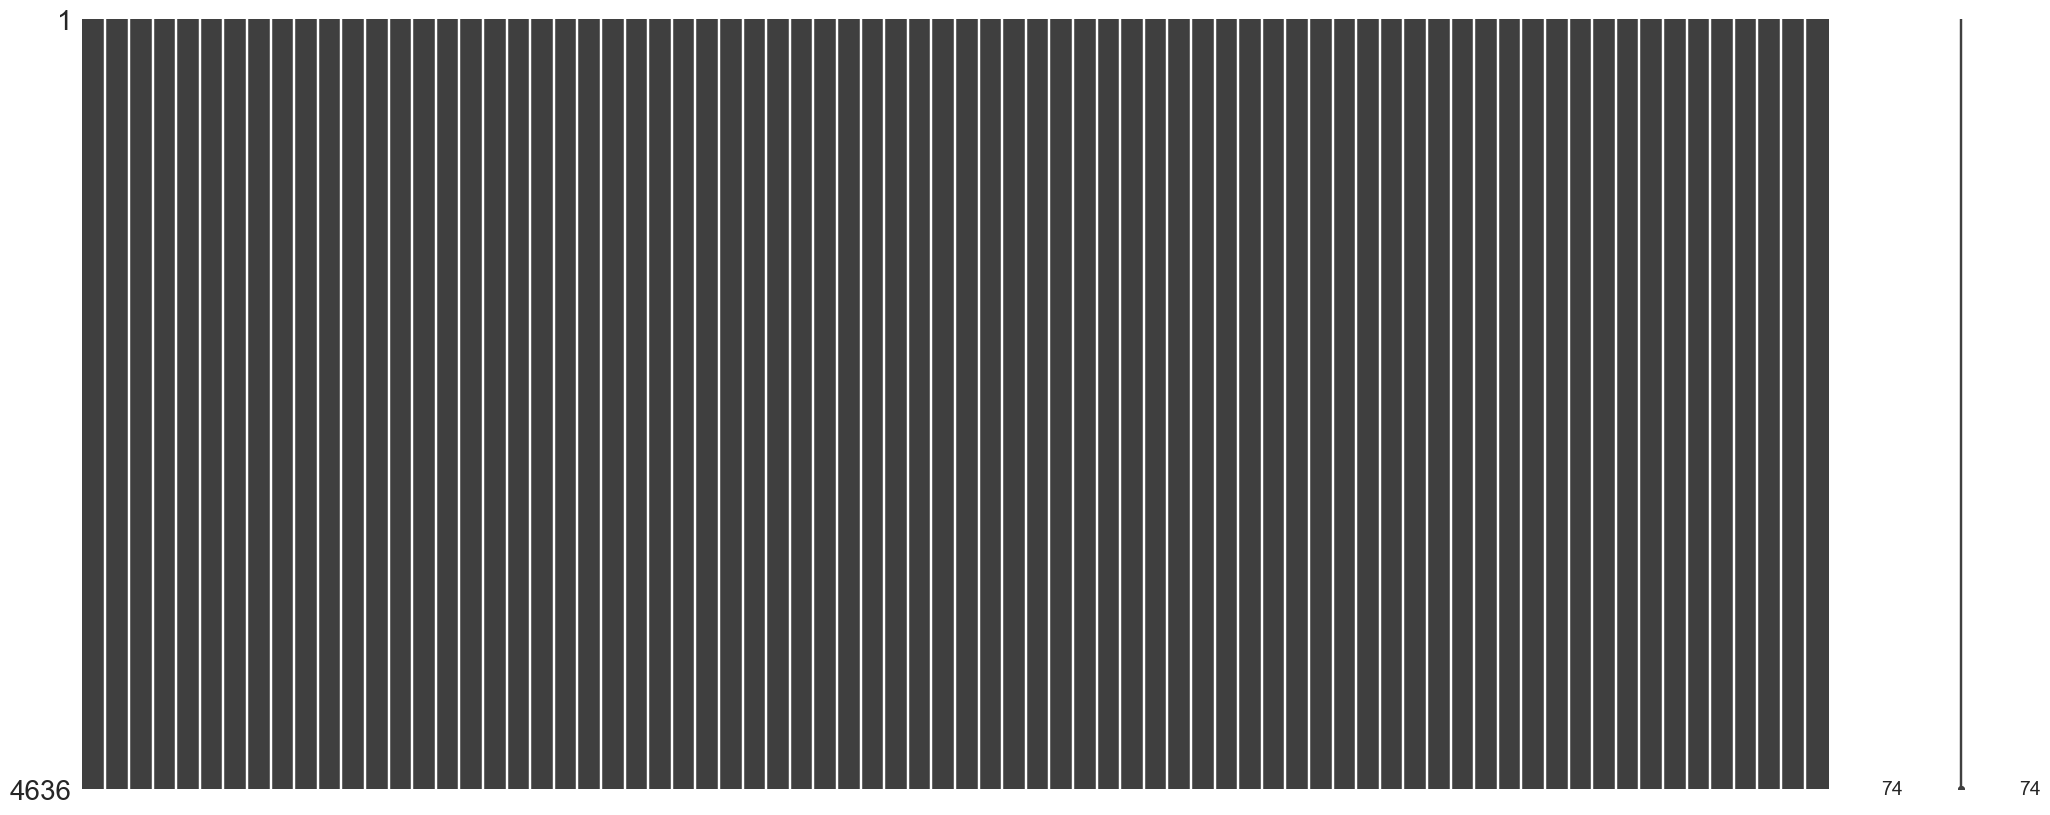

In [9]:
msngo.matrix(df_prep)
plt.show()

**Comentarios:**

Luego de realizar el preprocesamiento de datos con el archivo que nos entregan, observamos que no quedan variables con datos nulos.

### **I. Modelo Arstmade**

#### **I.I Preprocesamiento Variable Objetivo Arstmade**

Para tratar la variable objetivo Arstmade, se realizará una binarización de esta, la cuál nos servirá para explorar y para modelar.

In [10]:
df_val['arstmade'] = np.where(df_val['arstmade']=='Y', 1, 0)
df_prep['arstmade'] = np.where(df_prep['arstmade']=='Y', 1, 0)

#### **I.II Grilla de modelos e Hiperparámetros**

In [11]:
rand_state = 123#1180

dict_modelos_arstmade = {
    'Bagging_Logistic':(BaggingClassifier(base_estimator=LogisticRegression(), random_state=rand_state, n_jobs=-1),{
            'model__n_estimators': [100, 150],
            'model__max_samples': [0.1, 0.5, 0.8, 1],
            'model__max_features': [0.1, 0,5, 0.6, 1],
            'model__base_estimator': [LogisticRegression(class_weight=[.96, .3]), LogisticRegression(class_weight=[.3, .96])]
    }),    
    'Random_Forest':(RandomForestClassifier(random_state=rand_state, n_jobs=-1), {
        'model__n_estimators': [50, 100, 150, 200, 300],
        'model__max_depth':[None, 5, 8, 10],
        'model__max_features': ['sqrt', None],
        'model__class_weight': ['balanced', 'balanced_subsample', {0:.96,1:.3}, {0:.3,1:.96}]
    }),
    'Gradient_Boosting_Classifier':(GradientBoostingClassifier(random_state=rand_state), {
        'model__learning_rate': np.linspace(0, 1, 11),
        'model__max_features': ['auto','sqrt','log2']
    })
}

### **II. Modelo Violence**

#### **II.I Preprocesamiento para crear Variable Objetivo Violence**

Para crear la variable objetivo Violence, utilizaremos las columnas pf_, las cuales nos indican que hay violencia en el procedimiento según la información entregada en el Excel.

In [12]:
df_violence = df_prep.copy()
df_val_violence =  df_val.copy()

* Obtenemos columnas que indican violencia.

In [13]:
violence = df_prep.filter(regex='^pf_', axis=1)
violence.columns

Index(['pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_ptwep', 'pf_baton',
       'pf_hcuff', 'pf_pepsp', 'pf_other'],
      dtype='object')

* Hacemos masking para crear nueva variable objetivo la cuál indicará violencia si es que en alguna de estas columnas marca "Y"

In [14]:
mask_train = (df_violence['pf_wall'] == 'Y') | (df_violence['pf_drwep'] == 'Y') |\
                (df_violence['pf_hands'] == 'Y') | (df_violence['pf_grnd'] == 'Y') |\
                (df_violence['pf_ptwep'] == 'Y') | (df_violence['pf_baton'] == 'Y')|\
                (df_violence['pf_hcuff'] == 'Y') | (df_violence['pf_pepsp'] == 'Y')|\
                (df_violence['pf_other'] == 'Y')

mask_val = (df_val_violence['pf_wall'] == 'Y') | (df_val_violence['pf_drwep'] == 'Y') |\
                (df_val_violence['pf_hands'] == 'Y') | (df_val_violence['pf_grnd'] == 'Y') |\
                (df_val_violence['pf_ptwep'] == 'Y') | (df_val_violence['pf_baton'] == 'Y')|\
                (df_val_violence['pf_hcuff'] == 'Y') | (df_val_violence['pf_pepsp'] == 'Y')|\
                (df_val_violence['pf_other'] == 'Y')

* Creamos variable con np.where en datos de entrenamiento y en datos de validación.

In [15]:
df_violence['violence'] = np.where(mask_train, 1, 0)
df_val_violence['violence'] = np.where(mask_val, 1, 0)

#### **II.II Grilla de modelos e Hiperparámetros**

In [16]:
dict_modelos_violence = {         
    'DecisionTree':(DecisionTreeClassifier(random_state=rand_state),{
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [2,4,6,8,10,12],
        'model__class_weight':[{0:.96,1:.3},{0:.3,1:.96}]        
    }),    
    'Gradient_Boosting_Classifier':(GradientBoostingClassifier(random_state=rand_state), {
        'model__learning_rate': np.linspace(0, 1, 11),
        'model__max_features': ['auto','sqrt','log2']
    }),
    'RFC':(RandomForestClassifier(random_state=rand_state, max_features='log2', max_depth=10, n_jobs=-1), {
        'model__n_estimators': [10,50,100,150,200,250],
        'model__class_weight': ['balanced', 'balanced_subsample', {0:.96,1:.3}, {0:.3,1:.96}]
    }),
    'LR': (LogisticRegression(random_state=rand_state, n_jobs=-1), {
        'model__C': [0.001, 0.01, 0.1, 1, 10],
        'model__penalty':['l1', 'l2'],
        'model__class_weight': [{0:.96,1:.3}, {0:.3,1:.96}]
    }),
     'SVC':(SVC(random_state=rand_state),{
            'model__kernel': ['rbf'],
            'model__C': [0.3,0.4, 0.5, 5.1, 5.2],
            'model__class_weight' : [{0:0.9,1:0.1}]
     }),
    'LinearSVC':(LinearSVC(random_state=rand_state),{
            'model__C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
            'model__class_weight' : [{0:0.9,1:0.1}]
     }),
     'Bernoulli Naive Bayes':(BernoulliNB(), {
        'model__alpha': [1e-4, 1e-3, 1e-2,]
     })
}

### **Probabilidad de que un individuo sea arrestado en un Barrio, condicional al género y raza**

In [109]:
df_prob = df_prep.groupby(['city', 'race','sex'])['arstmade'].value_counts('%')

df_prob = df_prob.rename_axis(['Barrio','Raza','Genero','Arresto']).reset_index(name='Probabilidad')
pd.set_option('display.max_rows',100)
df_prob_arresto = df_prob[df_prob['Arresto']==1]

<AxesSubplot:xlabel='Probabilidad', ylabel='Raza'>

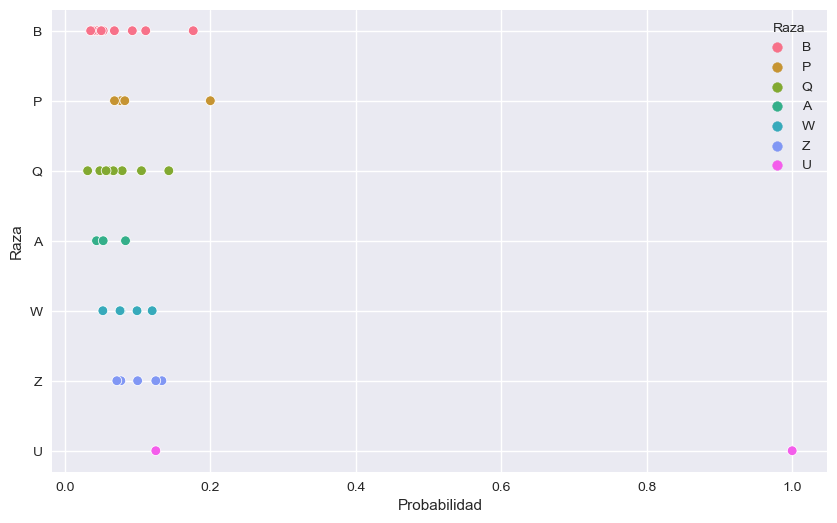

In [157]:
sns.scatterplot(data=df_prob_arresto[['Raza','Probabilidad']], y='Raza', x='Probabilidad', hue='Raza')

<AxesSubplot:xlabel='Genero', ylabel='Probabilidad'>

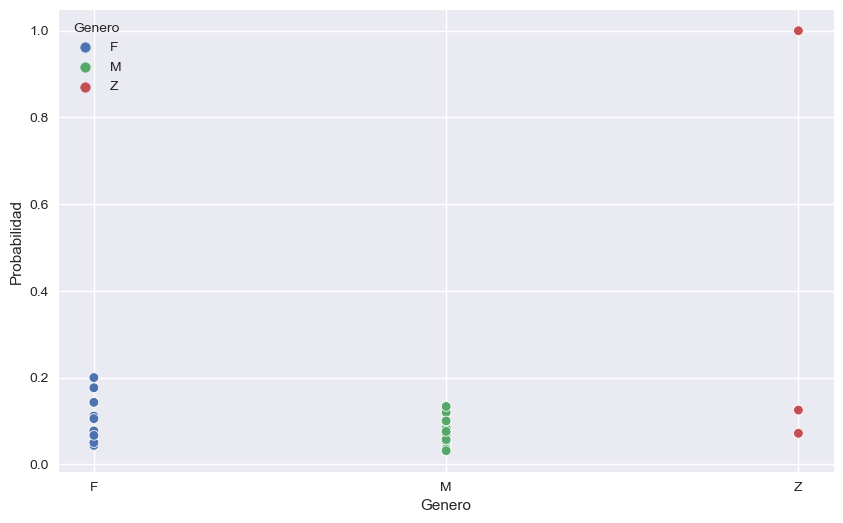

In [146]:
sns.scatterplot(data=df_prob_arresto[['Genero','Probabilidad']], y='Probabilidad', x='Genero', hue='Genero')

**Comentarios:**

* Las razas que tienen más probabilidad de ser arrestadas son los
de raza Negra y Negra Hispana
* Las mujeres tienen mas probabilidad de ser arrestadas, pero
son más casos de hombres arrestados
* El barrio donde hay mayor probabilidad de que ocurran 
arrestos es Manhattan

---
---

<center><h1><b>Arstmade: Análisis Exploratorio</b></h1></center>

## **3.1 Exploración Variable Objetivo Arstmade**

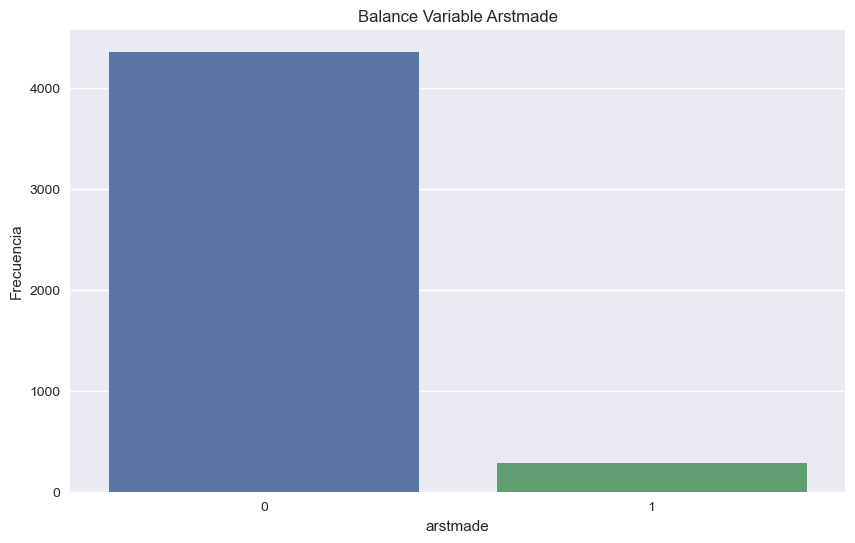

In [20]:
sns.countplot(data=df_prep, x='arstmade')
plt.title('Balance Variable Arstmade');
plt.ylabel('Frecuencia');

In [21]:
df_prep['arstmade'].value_counts()

0    4355
1     281
Name: arstmade, dtype: int64

**Comentarios:**

Notamos un claro desbalance de clases en la variable objetivo "arstmade", por lo tanto, la métrica de desempeño para obtener el mejor modelo será por F1 score. También nos plantearemos un Oversampling en el cual verificaremos si este mejora o no los puntajes.

## **Exploración Geográfica de procedimientos terminados en Arresto**

In [22]:
geo_arstmade = df[df['arstmade']=='Y'][['xcoord','ycoord','city']]

geo_arstmade['xcoord'] = geo_arstmade['xcoord'].apply(del_first_zero)
geo_arstmade['ycoord'] = geo_arstmade['ycoord'].apply(del_first_zero)

geo_arstmade['xcoord'] = np.where(geo_arstmade['xcoord']==' ', np.nan, geo_arstmade['xcoord'])
geo_arstmade['ycoord'] = np.where(geo_arstmade['ycoord']==' ', np.nan, geo_arstmade['ycoord'])

geo_arstmade = geo_arstmade.dropna()

In [23]:
geo_arstmade['xcoord'] = geo_arstmade['xcoord'].astype('int64')
geo_arstmade['ycoord'] = geo_arstmade['ycoord'].astype('int64')

geo_arstmade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 12 to 5810
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   xcoord  341 non-null    int64 
 1   ycoord  341 non-null    int64 
 2   city    341 non-null    object
dtypes: int64(2), object(1)
memory usage: 10.7+ KB


Text(0.5, 1.0, 'Geográfico de Arrestos')

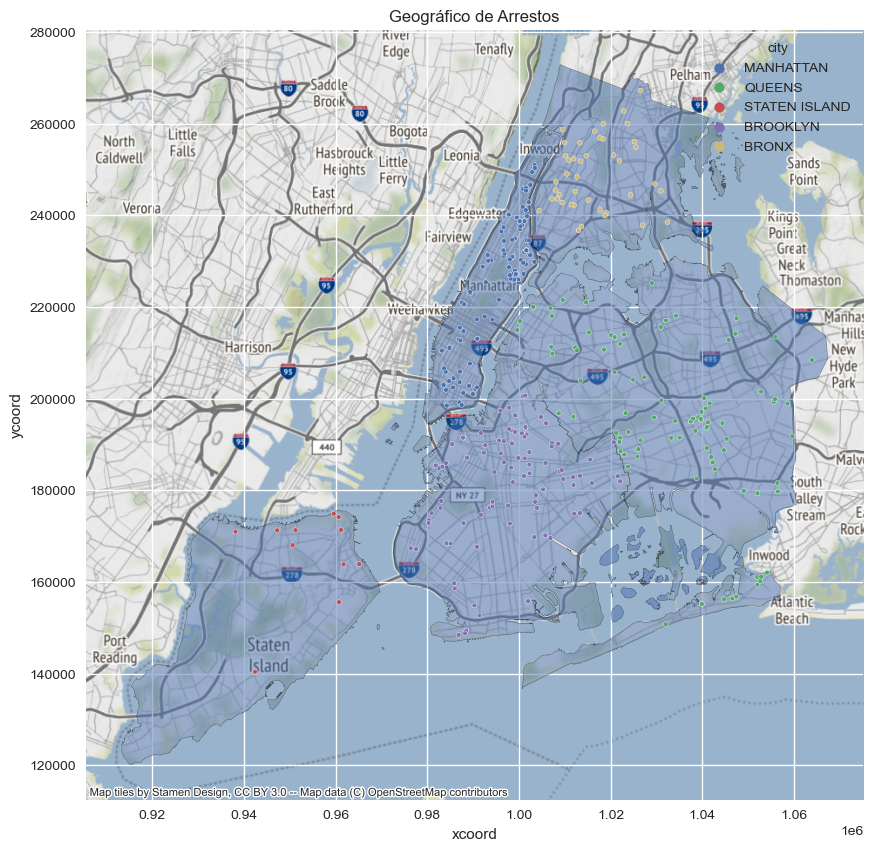

In [24]:
df_geo = gpd.read_file(gpd.datasets.get_path('nybb'))
df_wm = df_geo.to_crs(epsg=3857)
ax = df_geo.plot(figsize=(15, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, crs=df_geo.crs)

sns.scatterplot(data=geo_arstmade, x='xcoord', y='ycoord', hue='city', marker='o', s=12)
plt.title('Geográfico de Arrestos')

In [25]:
geo_arstmade.city.value_counts()

MANHATTAN        107
BROOKLYN          91
QUEENS            90
BRONX             42
STATEN ISLAND     11
Name: city, dtype: int64

**Observaciones:**

* Staten Island es el barrio con menos arrestos y en el mapa se encuentra bastante disperso comparado con los otros barrios.

* Manhattan es el barrio con más arrestos y más concentrado geográficamente.

* Geográficamente cuando los barrios con mayores arrestos se juntan, los casos terminados en arrestos aumentan. Si observamos Bronx, un barrio con menos arrestos, cuando se junta con Manhattan pareciera que la cantidad de arrestos aumenta, podríamos hablar de que barrios peligrosos influencian en sus alrededores.

## **3.2 Exploración Variables Atributos**

Para explorar los atributos, buscaremos las 5 variables que tienen una mayor correlación con la variable objetivo.

El proceso consta de los siguientes pasos:

* OrdinalEncoder para pasar variables categoricas a númericas.

* Buscar los 5 atributos con una mayor correlación.

* Gráficar frecuencia de los atributos.

* Gráficar con regplot para ver como afectan los atributos en la variable objetivo.

In [26]:
# Pasamos variables categóricas a númericas.

ode = OrdinalEncoder(encoding_method='arbitrary')
df_prep_ode = ode.fit_transform(df_prep)

In [27]:
# Encontramos los 5 atributos con mayor correlación. Aprovechamos de eliminar variable objetivo arstmade.

high_corr_vars = df_prep_ode.corr()[['arstmade']].abs().sort_values(by = 'arstmade', ascending = False).head(6).index

high_corr_vars = list(high_corr_vars.drop('arstmade'))

dict_high_cors = {
    'sb_other':'Base de búsqueda',
    'searched':'Buscado',
    'pf_hcuff': 'Fuerza por parte de Policia - Esposas',
    'contrabn': 'Contrabando encontrado',
    'rf_othsw': 'Motivo de cacheo - Sospecha de armas'
}

df_prep_ode.corr()[['arstmade']].abs().sort_values(by = 'arstmade', ascending = False).head(6)

,arstmade
arstmade,1.000000
sb_other,0.629970
searched,0.510214
pf_hcuff,0.465178
contrabn,0.424714
rf_othsw,0.312621


Variables con mayor correlación:

* sb_other: Base de búsqueda - Otra.

* searched: El sospechoso era buscado.

* pf_hcuff: Fuerza física utilizada por el oficial - Esposas.

* contrabn: Contrabando encontrado en el sospechoso.

* rf_othsw: Motivo de cacheo - Otra sospecha de armas.

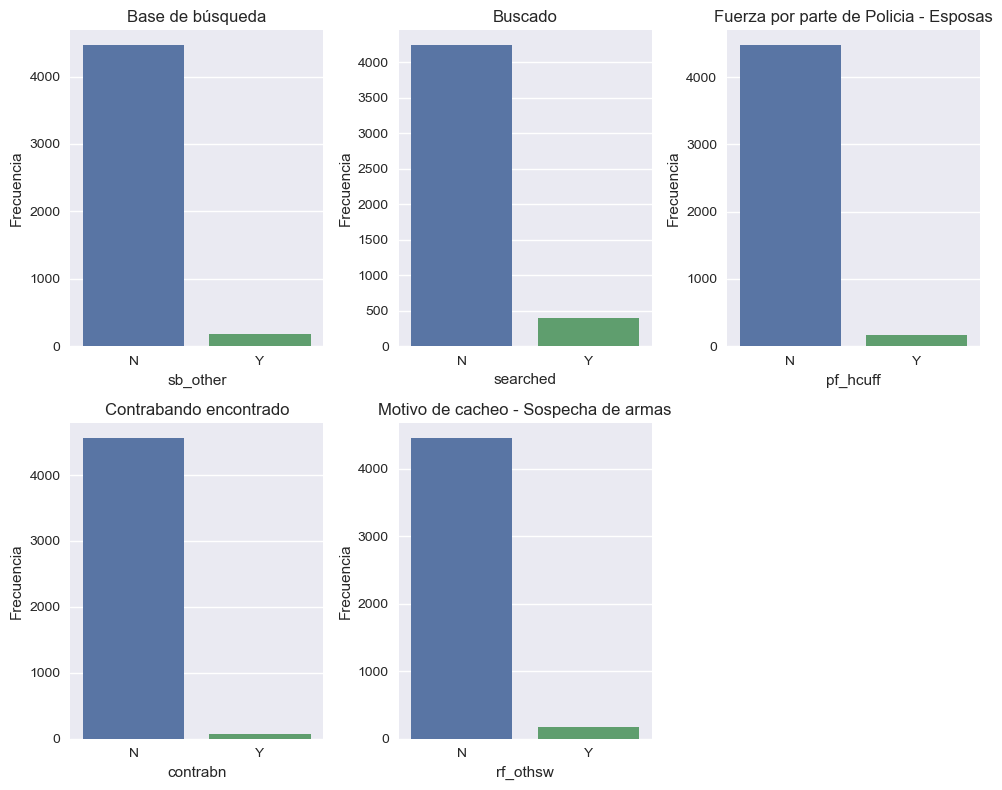

In [28]:
nrows = len(high_corr_vars)/2
ncolumns = len(high_corr_vars)

plt.figure(figsize=(10,8))

contador = 0
for key, item in dict_high_cors.items():    
    contador +=1
    plt.subplot(2, 3, contador)
    sns.countplot(data=df_prep, x=key)
    plt.title(item)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    

**Comentarios:**

Se aprecia un alto desbalance de Clases por cada variable encontrada. Observemos como se comportan con regplot contra la variable objetivo.

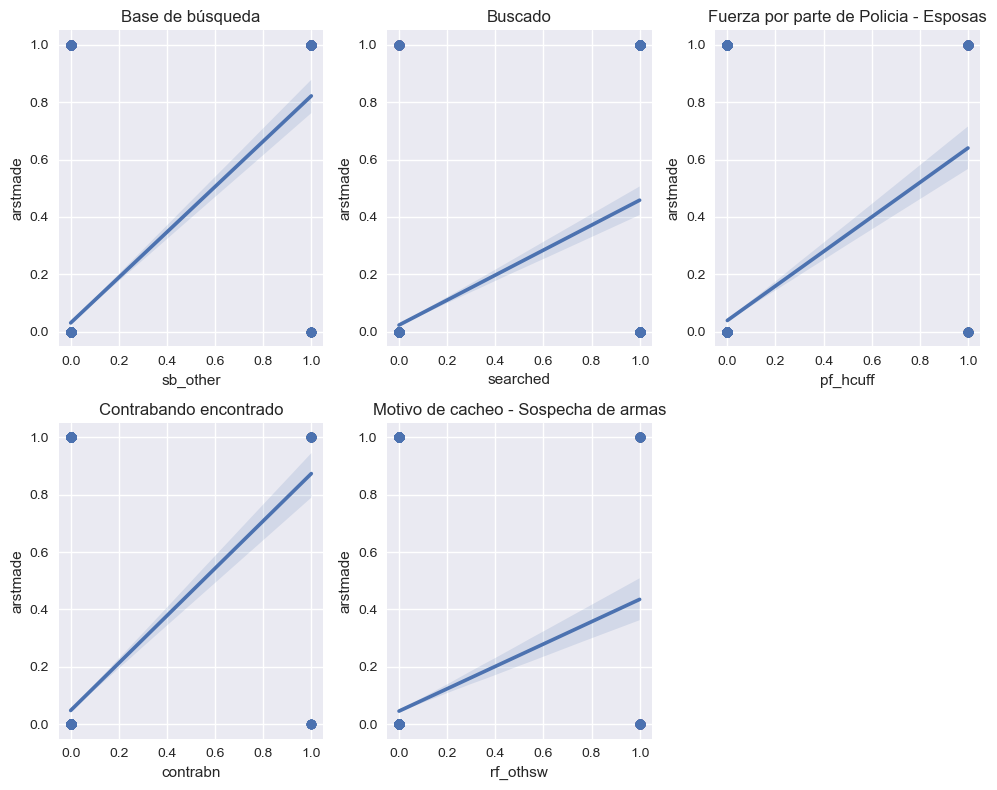

In [29]:
nrows = len(high_corr_vars)//2
ncolumns = len(high_corr_vars)

df_plot_attributes = df_prep.loc[:,['sb_other', 'searched', 'pf_hcuff', 'contrabn', 'rf_othsw','arstmade']]

ode_plot = OrdinalEncoder(encoding_method='arbitrary')
df_plot_attributes_ode = ode_plot.fit_transform(df_plot_attributes)

plt.figure(figsize=(10,8))

contador = 0
for key, item in dict_high_cors.items():
    contador +=1    
    plt.subplot(2, 3, contador)
    sns.regplot(data=df_plot_attributes_ode, x=key, y='arstmade', )
    plt.ylabel('arstmade')
    plt.title(item)
    plt.tight_layout()

**Comentarios:**

Mediante los gráficos observamos que en todas las variables al marcar como Clase 1, la probabilidad de ser arrestado aumenta. Esto es lo más lógico si pensamos en alguien que está siendo buscado, donde se hay sospecha de armas y que además se encontró contrabando.

## **Exploración Geográfica de Contrabando**

In [30]:
geo_contrabn = df[df['contrabn']=='Y'][['xcoord','ycoord','city']]

geo_contrabn['xcoord'] = geo_contrabn['xcoord'].apply(del_first_zero)
geo_contrabn['ycoord'] = geo_contrabn['ycoord'].apply(del_first_zero)

geo_contrabn['xcoord'] = np.where(geo_contrabn['xcoord']==' ', np.nan, geo_contrabn['xcoord'])
geo_contrabn['ycoord'] = np.where(geo_contrabn['ycoord']==' ', np.nan, geo_contrabn['ycoord'])

geo_contrabn = geo_contrabn.dropna()

In [31]:
geo_contrabn['xcoord'] = geo_contrabn['xcoord'].astype('int64')
geo_contrabn['ycoord'] = geo_contrabn['ycoord'].astype('int64')

geo_contrabn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 26 to 5661
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   xcoord  88 non-null     int64 
 1   ycoord  88 non-null     int64 
 2   city    88 non-null     object
dtypes: int64(2), object(1)
memory usage: 2.8+ KB


Text(0.5, 1.0, 'Geográfico de Contrabando')

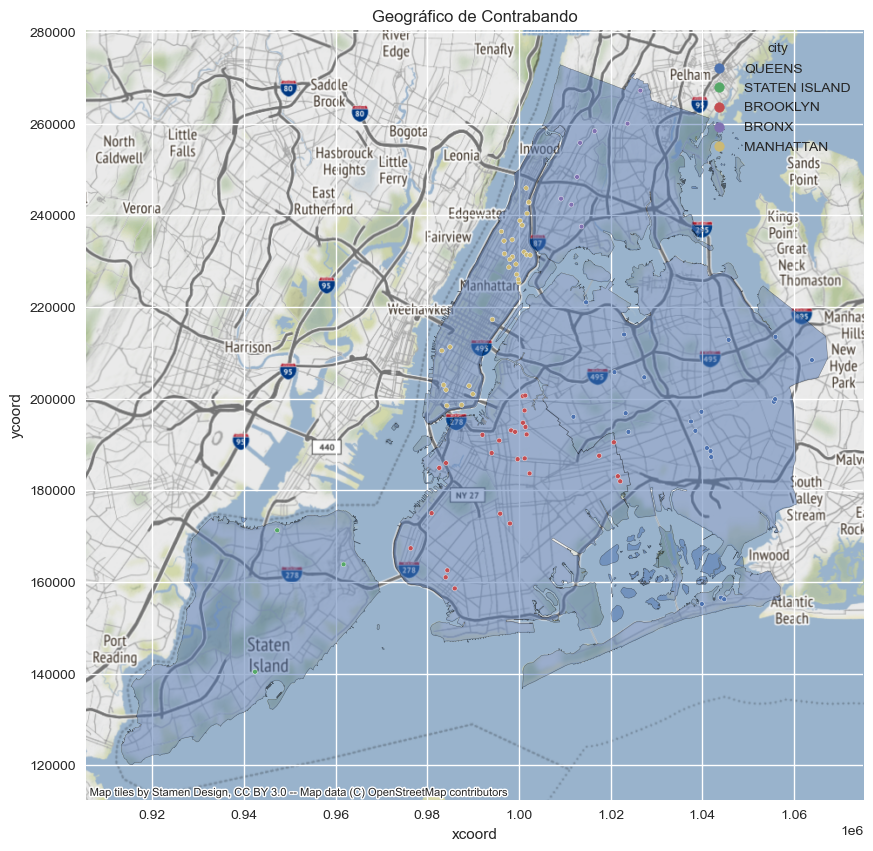

In [32]:
df_geo = gpd.read_file(gpd.datasets.get_path('nybb'))
df_wm = df_geo.to_crs(epsg=3857)
ax = df_geo.plot(figsize=(15, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, crs=df_geo.crs)

sns.scatterplot(data=geo_contrabn, x='xcoord', y='ycoord', hue='city', marker='o', s=12)
plt.title('Geográfico de Contrabando')

**Observaciones:**

* Staten Island tiene el contrabando más bajo. 

* Dada la baja cantidad de arrestos y contrabando en State Island, podemos decir que este es el Barrio más seguro de New York.

* Los barrios con más contrabando serían Manhattan y Brooklyn.

---

<center><h1><b>Arstmade: Modelamiento</b></h1></center>

#### **4.1 División de muestras**

In [33]:
X_train = df_prep.loc[:,high_corr_vars]
y_train = df_prep.arstmade

In [34]:
X_test = df_val.loc[:,high_corr_vars]
y_test = df_val.arstmade

#### **4.2 Entrenamiento y búsqueda de Hiperparámetros**

In [35]:
data, modelos = gridsearch_train(dict_modelos_arstmade, X_train, X_test, y_train, y_test, high_corr_vars)

**Buscamos modelo con mayor puntaje**

In [36]:
data.sort_values(by='f1_weighted', ascending=False)

,best_score,best_params,f1_weighted
Gradient_Boosting_Classifier,0.9675,"{'model__learning_rate': 0.1, 'model__max_feat...",0.961823
Random_Forest,0.9654,"{'model__class_weight': {0: 0.3, 1: 0.96}, 'mo...",0.959648
Bagging_Logistic,0.9626,{'model__base_estimator': LogisticRegression(c...,0.958596


#### **Comentarios:**

Observamos que Gradient Boosting Classifier nos entrega el mejor puntaje en cuanto a F1 weighted y best score

In [37]:
model_gb = modelos['Gradient_Boosting_Classifier']

**Mejores hiperparámetros**

In [38]:
data_grid_gb = pd.DataFrame(model_gb.cv_results_)
model_gb.best_params_

{'model__learning_rate': 0.1, 'model__max_features': 'sqrt'}

**Observación de Overfitting**

In [39]:
data_grid_gb[data_grid_gb['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_features,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,0.146807,0.004297,0.012766,0.002475,0.1,sqrt,"{'model__learning_rate': 0.1, 'model__max_feat...",0.965881,0.963527,0.973652,...,0.967517,0.003767,1,0.967914,0.968493,0.966001,0.966885,0.968262,0.967511,0.000934
5,0.154646,0.017993,0.011569,0.001739,0.1,log2,"{'model__learning_rate': 0.1, 'model__max_feat...",0.965881,0.963527,0.973652,...,0.967517,0.003767,1,0.967914,0.968493,0.966001,0.966885,0.968262,0.967511,0.000934


Observando mean_train_score y mean_test_score encontramos que hay una **mínima diferencia**.

#### **Reporte de métricas**

In [40]:
print(classification_report(y_test, model_gb.best_estimator_.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.9747    0.9865    0.9805      5613
           1     0.7711    0.6400    0.6995       400

    accuracy                         0.9634      6013
   macro avg     0.8729    0.8132    0.8400      6013
weighted avg     0.9611    0.9634    0.9618      6013



**Observaciones:**

* Encontramos una mínima diferencia entre puntajes de train y validación, por lo tanto, tenemos un modelo generalizado.

* Contamos con un excelente accuracy de validación y además un buen puntaje en F1.

* Desempeño de clases se encuentra balanceado, por lo tanto, no aplicaremos Oversampling.

---
---

<center><h1><b>Violence: Análisis Exploratorio</b></h1></center>

## **3.1 Exploración Variable Objetivo Violence**

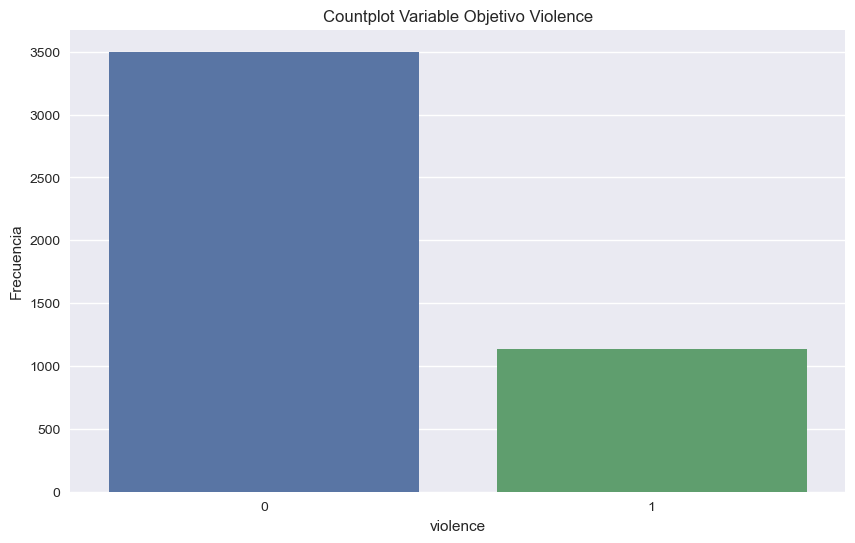

In [41]:
sns.countplot(data=df_violence, x='violence')
plt.ylabel('Frecuencia')
plt.title('Countplot Variable Objetivo Violence');

**Comentarios:**

Se observa un claro desbalance de Clases en el vector objetivo "violence", debido a esto, para elegir nuestro mejor modelo nos guíaremos por el F1 score obtenido prediciendo en la data de validación.

## **3.1 Exploración Variables Atributos**

Para explorar los atributos, buscaremos las 5 variables que tienen una mayor correlación con la variable objetivo.

El proceso consta de los siguientes pasos:

* OrdinalEncoder para pasar variables categoricas a númericas.

* Buscar los 5 atributos con una mayor correlación.

* Gráficar frecuencia de los atributos.

* Gráficar con regplot para ver como afectan los atributos en la variable objetivo.

In [42]:
lista_columnas = violence.columns.to_list() # Obtenemos lista de columnas que indican violencia

In [43]:
ode = OrdinalEncoder(encoding_method='arbitrary')
df_prep_violence_ode = df_violence.drop(columns=lista_columnas) # Dropeamos columnas que indican violencia
df_prep_violence_ode = ode.fit_transform(df_prep_violence_ode) # Transformamos a números la data de violence

In [44]:
high_corr_vars_violence = df_prep_violence_ode.corr()[['violence']].abs().sort_values(by = 'violence', ascending = False).head(7).index

high_corr_vars_violence = list(high_corr_vars_violence.drop('violence'))

dict_high_cors_violence = {
    'frisked':'Sujeto fue registrado',
    'rf_furt':'Motivo de Cacheo - Momentos furtivos',
    'rf_vcrim': 'Motivo de Cacheo - Sospecha de delito Violento',
    'searched': 'Buscado',
    'rf_rfcmp': 'Motivo de cacheo - Se niega a cumplir ordenes',
    'sb_hdobj': 'Base de búsqueda - Objeto duro'
}
# Obtenemos variables con mayor correlación contra la variable objetivo
df_prep_violence_ode.corr()[['violence']].abs().sort_values(by = 'violence', ascending = False).head(7)

,violence
violence,1.000000
frisked,0.422536
rf_furt,0.297167
rf_vcrim,0.202429
searched,0.193058
rf_rfcmp,0.161196
sb_hdobj,0.140678


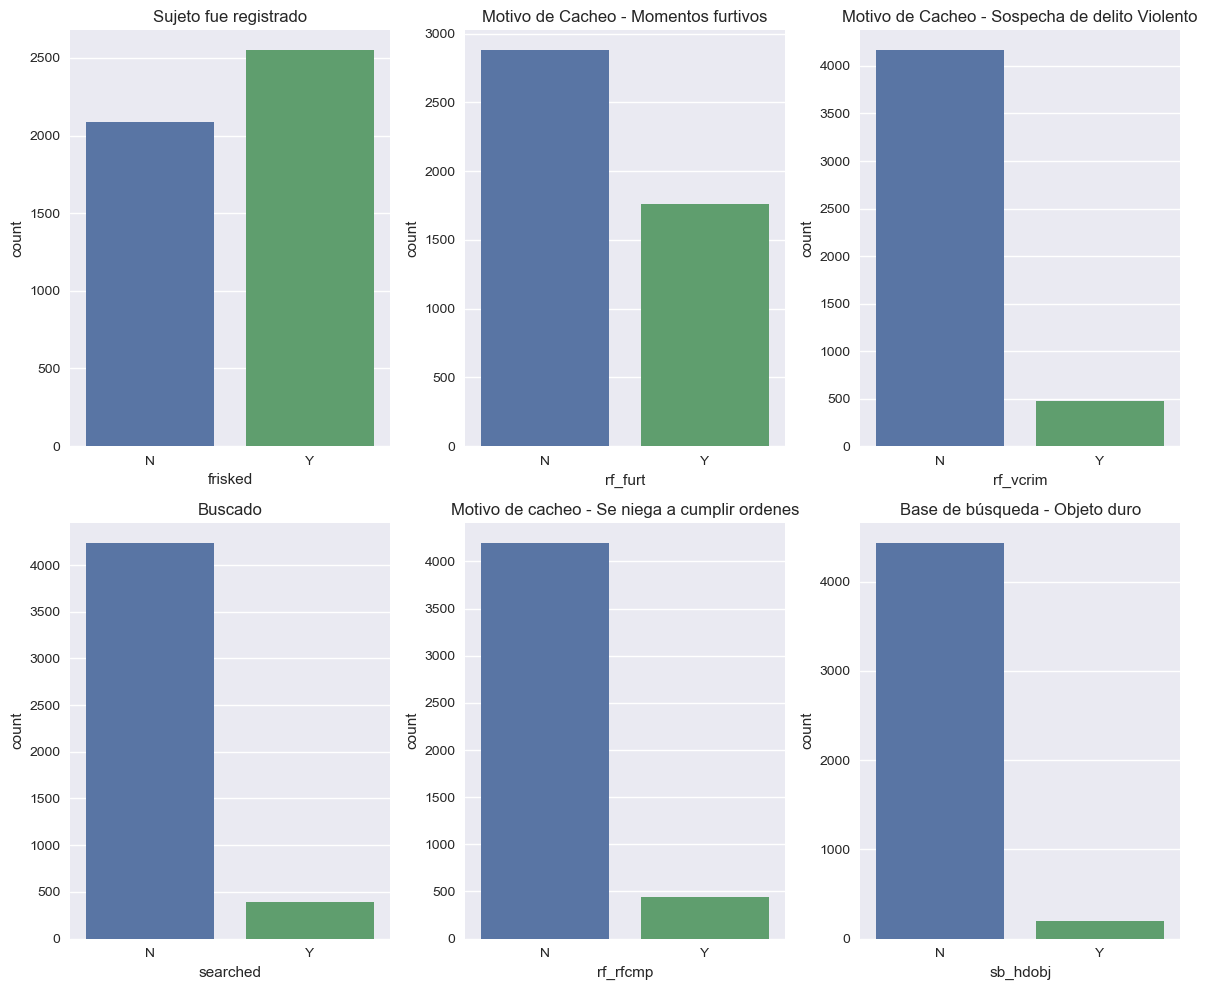

In [45]:
plt.figure(figsize=(12,10))

contador = 0
for key, item in dict_high_cors_violence.items():
    contador +=1
    plt.subplot(2, 3, contador)
    sns.countplot(data=df_violence, x=key)
    plt.title(item)
    plt.tight_layout()

**Comentarios:**

Las variables atributos con más desbalance corresponden a searched, rf_rfcmp, sb_hdobj y rf_vcrim. Justamente son las variables que podemos asociar más con violencia. Observemos más de cerca como se comportan contra la variable objetivo "violence".

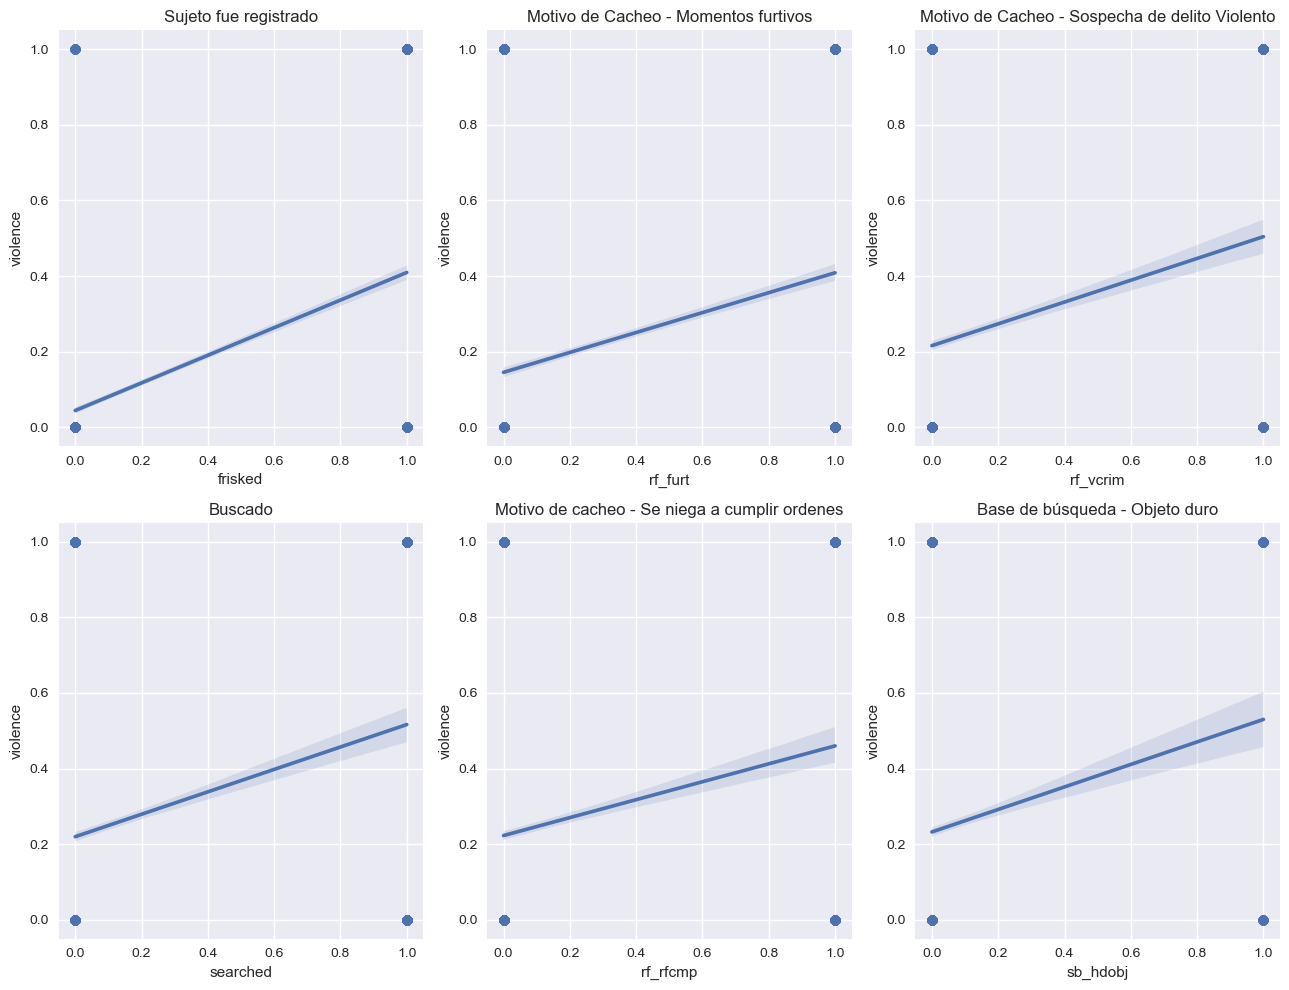

In [46]:
nrows = len(high_corr_vars_violence)/2
ncolumns = len(high_corr_vars_violence)

df_plot_attributes_violence = df_violence.loc[:,['frisked', 'rf_furt', 'rf_vcrim', 'searched', 'rf_rfcmp', 'sb_hdobj', 'violence']]

ode_plot_violence = OrdinalEncoder(encoding_method='arbitrary')
df_plot_attributes_ode_violence = ode_plot_violence.fit_transform(df_plot_attributes_violence)

plt.figure(figsize=(13,10))
contador = 0
for key, item in dict_high_cors_violence.items():
    contador +=1
    plt.subplot(2, 3, contador)
    sns.regplot(data=df_plot_attributes_ode_violence, x=key, y='violence', )
    plt.title(item)
    plt.ylabel('violence')
    plt.tight_layout()

**Comentarios:**

Al igual que las variables atributos de "arstmade", en "violence" observamos el mismo fenómeno, todas tienen una correlación positiva que nos indican una mayor probabilidad de ocurrencia al pertenecer a la Clase 1.

## **Exploración Geográfica de Violencia**

In [47]:
df_violence_geo = df.copy()

In [48]:
mask_geo_violence = (df_violence_geo['pf_wall'] == 'Y') | (df_violence_geo['pf_drwep'] == 'Y') |\
                (df_violence_geo['pf_hands'] == 'Y') | (df_violence_geo['pf_grnd'] == 'Y') |\
                (df_violence_geo['pf_ptwep'] == 'Y') | (df_violence_geo['pf_baton'] == 'Y')|\
                (df_violence_geo['pf_hcuff'] == 'Y') | (df_violence_geo['pf_pepsp'] == 'Y')|\
                (df_violence_geo['pf_other'] == 'Y')

In [49]:
df_violence_geo['violence'] = np.where(mask_geo_violence, 1, 0)

In [50]:
geo_violence = df_violence_geo[df_violence_geo['violence']==1][['xcoord','ycoord','city']]

geo_violence['xcoord'] = geo_violence['xcoord'].apply(del_first_zero)
geo_violence['ycoord'] = geo_violence['ycoord'].apply(del_first_zero)

geo_violence['xcoord'] = np.where(geo_violence['xcoord']==' ', np.nan, geo_violence['xcoord'])
geo_violence['ycoord'] = np.where(geo_violence['ycoord']==' ', np.nan, geo_violence['ycoord'])

geo_violence= geo_violence.dropna()

In [51]:
geo_violence['xcoord'] = geo_violence['xcoord'].astype('int64')
geo_violence['ycoord'] = geo_violence['ycoord'].astype('int64')

geo_violence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413 entries, 8 to 5810
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   xcoord  1413 non-null   int64 
 1   ycoord  1413 non-null   int64 
 2   city    1413 non-null   object
dtypes: int64(2), object(1)
memory usage: 44.2+ KB


Text(0.5, 1.0, 'Geográfico de Violencia')

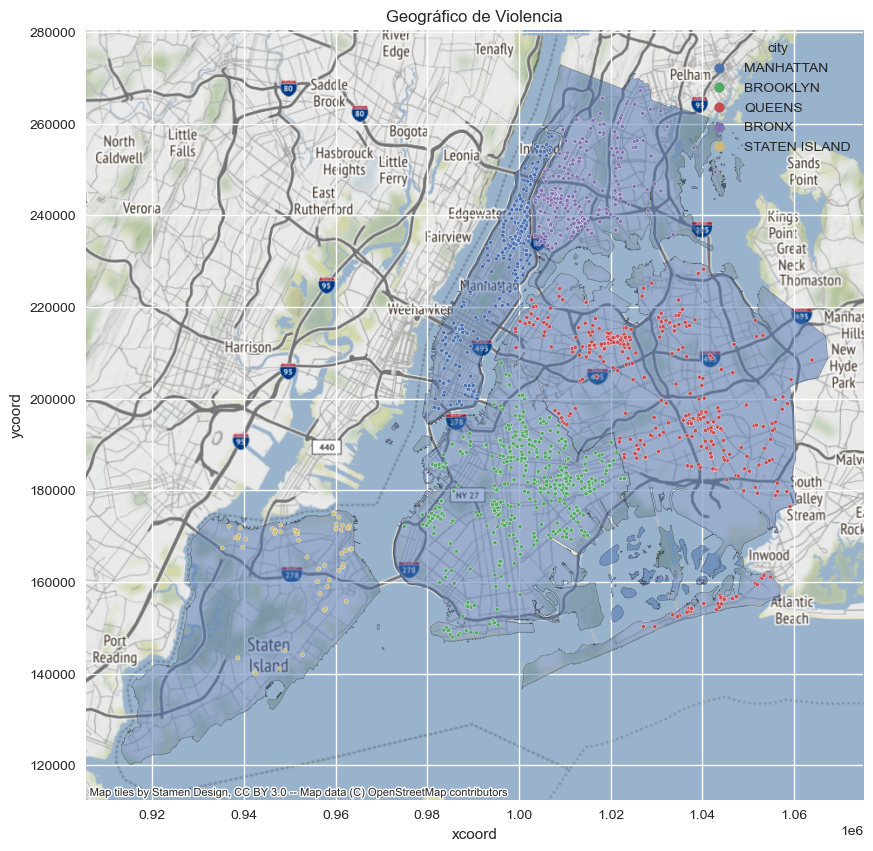

In [52]:
df_geo = gpd.read_file(gpd.datasets.get_path('nybb'))
df_wm = df_geo.to_crs(epsg=3857)
ax = df_geo.plot(figsize=(15, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, crs=df_geo.crs)

sns.scatterplot(data=geo_violence, x='xcoord', y='ycoord', hue='city', marker='o', s=9)
plt.title('Geográfico de Violencia')

In [53]:
geo_violence.city.value_counts()

BROOKLYN         435
QUEENS           358
MANHATTAN        309
BRONX            254
STATEN ISLAND     57
Name: city, dtype: int64

**Observaciones:**

* Nuevamente Staten Island aparece de los últimos, indicando un barrio más seguro que los demás.

* A pesar de que Bronx tuvo una menor cantidad de arrestos y contrabando, igualmente lo podemos considerar como un barrio violento por parte de los sujetos que son procesados.

* Si bien Manhattan tenia la mayor cantidad de arrestos de los 3 barrios, este se encuentra por debajo de ellos.

---

<center><h1><b>Violence: Modelamiento</b></h1></center>

#### **4.1 División de muestras**

* Conjunto de entrenamiento.

> Contamos con una Clase llamada "SelectFeatures" que selecciona las columnas a nuestra disposición, de esta manera, cuando serializemos los modelos, podrá predecirse en cualquier dataframe que cuente con estas mismas columnas.

In [54]:
X_train_violence = df_violence.loc[:,high_corr_vars_violence]
y_train_violence = df_violence.violence

* Conjunto de validación

In [55]:
X_test_violence = df_val_violence.loc[:,high_corr_vars_violence]
y_test_violence = df_val_violence.violence

#### **4.2 Entrenamiento y búsqueda de Hiperparámetros**

In [56]:
data_violence, modelos_violence = gridsearch_train(dict_modelos_violence, X_train_violence, X_test_violence, y_train_violence, y_test_violence, high_corr_vars_violence)

In [57]:
data_violence.sort_values(by='f1_weighted', ascending=False)

,best_score,best_params,f1_weighted
Bernoulli Naive Bayes,0.7366,{'model__alpha': 0.0001},0.736037
Gradient_Boosting_Classifier,0.7093,"{'model__learning_rate': 0.1, 'model__max_feat...",0.701102
LinearSVC,0.6508,"{'model__C': 1000.0, 'model__class_weight': {0...",0.700586
LR,0.6777,"{'model__C': 0.001, 'model__class_weight': {0:...",0.662787
RFC,0.6762,"{'model__class_weight': 'balanced', 'model__n_...",0.661905
DecisionTree,0.6766,"{'model__class_weight': {0: 0.3, 1: 0.96}, 'mo...",0.661055
SVC,0.6495,"{'model__C': 0.3, 'model__class_weight': {0: 0...",0.653914


**Comentarios:**

Escogeremos por puntaje de validación a los dos mejores, los cuales serían:

* Bernoulli Naive Bayes con un F1_weighted de 0.736037

* Gradient Boosting Classifier con un F1_weighted de 0.701102

**Obtención de modelos**

In [58]:
model_nb = modelos_violence['Bernoulli Naive Bayes']
model_gb = modelos_violence['Gradient_Boosting_Classifier']

#### **Inspeccionamos Overfitting de los resultados de GridSearch: Bernoulli Naive Bayes**

In [59]:
data_grid_nb = pd.DataFrame(model_nb.cv_results_)

data_grid_nb#.loc[0][['mean_train_score','mean_test_score']]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.026237,0.001201,0.012367,0.005300,0.0001,{'model__alpha': 0.0001},0.736067,0.738144,0.727017,0.744321,...,0.736582,0.005562,1,0.736882,0.736305,0.73914,0.734828,0.736399,0.736711,0.001395
1,0.035904,0.007929,0.016897,0.013463,0.001,{'model__alpha': 0.001},0.736067,0.738144,0.727017,0.744321,...,0.736582,0.005562,1,0.736882,0.736305,0.73914,0.734828,0.736399,0.736711,0.001395
2,0.029425,0.001353,0.009973,0.000892,0.01,{'model__alpha': 0.01},0.736067,0.738144,0.727017,0.744321,...,0.736582,0.005562,1,0.736882,0.736305,0.73914,0.734828,0.736399,0.736711,0.001395


> Observando mean_train_score y mean_test_score encontramos que hay una **mínima diferencia** y está dentro de lo óptimo.

#### **Inspeccionamos Overfitting de los resultados del GridSearch: Gradient Boosting Classifier**

In [60]:
data_grid_gb = pd.DataFrame(model_gb.cv_results_)

data_grid_gb[data_grid_gb['rank_test_score']==1]#.loc[0][['mean_train_score','mean_test_score']]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_features,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,0.29606,0.052119,0.018152,0.004609,0.1,auto,"{'model__learning_rate': 0.1, 'model__max_feat...",0.714736,0.706725,0.698249,...,0.709264,0.009316,1,0.728033,0.712,0.72078,0.728845,0.707382,0.719408,0.008542


> Observando mean_train_score y mean_test_score encontramos que hay una **mínima diferencia** y está dentro de lo óptimo, con un leve overfitting.

**Reporte de desempeño**

In [61]:
print('                Modelo Bernoulli Naive Bayes')
print(classification_report(y_test_violence, model_nb.best_estimator_.predict(X_test_violence), digits=4))
print('         ')
print('                Modelo Gradient Boosting Classifier')
print(classification_report(y_test_violence, model_gb.best_estimator_.predict(X_test_violence), digits=4))

                Modelo Bernoulli Naive Bayes
              precision    recall  f1-score   support

           0     0.8094    0.8763    0.8415      4559
           1     0.4763    0.3528    0.4054      1454

    accuracy                         0.7497      6013
   macro avg     0.6428    0.6146    0.6234      6013
weighted avg     0.7288    0.7497    0.7360      6013

         
                Modelo Gradient Boosting Classifier
              precision    recall  f1-score   support

           0     0.7761    0.9579    0.8575      4559
           1     0.5026    0.1334    0.2109      1454

    accuracy                         0.7585      6013
   macro avg     0.6393    0.5457    0.5342      6013
weighted avg     0.7099    0.7585    0.7011      6013



**Comentarios:**

 * Los dos modelos tienen un accuracy parecido, sin una gran diferencia del 0.0087.
 
 * En ambos el desempeño de Clases se encuentra muy desbalanceado en cuanto a recall, por lo que penaliza el F1 score.

 Debido a esto último, realizaremos una nueva búsqueda de grilla en estos dos puntajes, pero con Oversampling.

#### **Oversampling Bernoulli Naive Bayes**

In [62]:
# Oversampler
oversampler = SMOTE(random_state=12, sampling_strategy='minority') #Instanciamos objeto con minority

#Transformamos X_train_violence en números
ode = OrdinalEncoder(encoding_method='arbitrary')
X_train_violence_ode = ode.fit_transform(X_train_violence)

X_sample, y_sample = oversampler.fit_sample(X_train_violence_ode, y_train_violence) #Realizamos el oversampling sobre datos de entrenamiento

**Comprobamos nuevos datos**

In [63]:
y_sample.value_counts()

0    3500
1    3500
Name: violence, dtype: int64

* Vector objetivo "violence" fue balanceado correctamente en cuanto a muestras.

**Realizamos búsqueda nuevamente con Oversampling**

In [64]:
params_bernoulli = {        
    'model__alpha': [1e-4, 1e-3, 1e-2,]  
}

pipe_over_bn = Pipeline([
                ('select', SelectFeatures(high_corr_vars_violence)),             
                ('model', BernoulliNB())
            ])

grid_search_over_bn = GridSearchCV(pipe_over_bn, params_bernoulli, cv = 5, scoring = 'f1_weighted', n_jobs = -1, return_train_score=True)

grid_search_over_bn.fit(X_sample, y_sample)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select',
                                        SelectFeatures(features_names=['frisked',
                                                                       'rf_furt',
                                                                       'rf_vcrim',
                                                                       'searched',
                                                                       'rf_rfcmp',
                                                                       'sb_hdobj'])),
                                       ('model', BernoulliNB())]),
             n_jobs=-1, param_grid={'model__alpha': [0.0001, 0.001, 0.01]},
             return_train_score=True, scoring='f1_weighted')

Para comprobar puntajes debemos pasar a datos númericos la data de validación:

In [65]:
X_test_violence_ode = ode.fit_transform(X_test_violence)

In [66]:
print(classification_report(y_test, grid_search_over_bn.best_estimator_.predict(X_test_violence_ode), digits = 4))

              precision    recall  f1-score   support

           0     0.9330    0.4563    0.6128      5613
           1     0.0661    0.5400    0.1178       400

    accuracy                         0.4618      6013
   macro avg     0.4995    0.4981    0.3653      6013
weighted avg     0.8753    0.4618    0.5799      6013



**Comentarios:**

Se observa una baja en todos los puntajes respecto a los calculos anteriores de f1 weighted sin smote. Podemos concluir que en este caso realizar un Oversampling empeora el desempeño.

#### **Oversampling Gradient Boosting Classifier**

**Búsqueda de Grilla**

In [67]:
params_gb = {        
    'model__learning_rate': np.linspace(0, 1, 11),
    'model__max_features': ['auto','sqrt','log2'] 
}

pipe_over_gb = Pipeline([
                ('select', SelectFeatures(high_corr_vars_violence)),             
                ('model', GradientBoostingClassifier())
            ])

grid_search_over_gb = GridSearchCV(pipe_over_gb, params_gb, cv = 5, scoring = 'accuracy', n_jobs = -1, return_train_score=True)

grid_search_over_gb.fit(X_sample, y_sample)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select',
                                        SelectFeatures(features_names=['frisked',
                                                                       'rf_furt',
                                                                       'rf_vcrim',
                                                                       'searched',
                                                                       'rf_rfcmp',
                                                                       'sb_hdobj'])),
                                       ('model',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__max_features': ['auto', 'sqrt', 'log2']},
             return_train_score=True, scoring='accuracy')

**Comprobamos nuevo desempeño**

In [68]:
print(classification_report(y_test_violence, grid_search_over_gb.best_estimator_.predict(X_test_violence_ode)))

              precision    recall  f1-score   support

           0       0.62      0.43      0.51      4559
           1       0.08      0.16      0.11      1454

    accuracy                           0.36      6013
   macro avg       0.35      0.30      0.31      6013
weighted avg       0.49      0.36      0.41      6013



**Comentarios:**

Al igual que el Oversampling realizado en el Bernoulli Naive Bayes, los puntajes bajan notablemente en todas las métricas, por lo tanto, concluimos que realizar un oversampling en cualquier de los dos modelos no es beneficioso para sus desempeños.

## **Mejores Modelos**

Luego de realizar la experimentación con Oversampling, reforzamos la conclusión de que los dos mejores modelos son:

* Bernoulli Naive Bayes con los parámetros:

    ``` py
    {'model__learning_rate': 0.1, 'model__max_features': 'auto'}
    ```

* Gradient Boosting Classfier con los parámetros:

    ``` py
    {'model__alpha': 0.0001}
    ```

<center><h1><b>Violence: Serialización</b></h1></center>

In [69]:
# Exportar
dump(model_nb.best_estimator_, 'tcj_modelo-1.sav')
dump(model_gb.best_estimator_, 'tcj_modelo-2.sav')

['tcj_g1_modelo-2.sav']

---